In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from tqdm import tqdm

# Approximating continuous functions with the barycentric neural network
Now, consider a function $f(x)$, where it is not necessary for it to be linear, as in the case of  $sin(x)$, but instead, it is continuous and maps from $\mathbb{R} \to \mathbb{R}$. We aim to divide this function into $n$ sub-functions, so that we can obtain a piecewise linear function (CPLF) that approximates the given non-linear function. Thanks to this representation of a CPLF through the BNN, this neural network can serve as a universal approximation of any function.


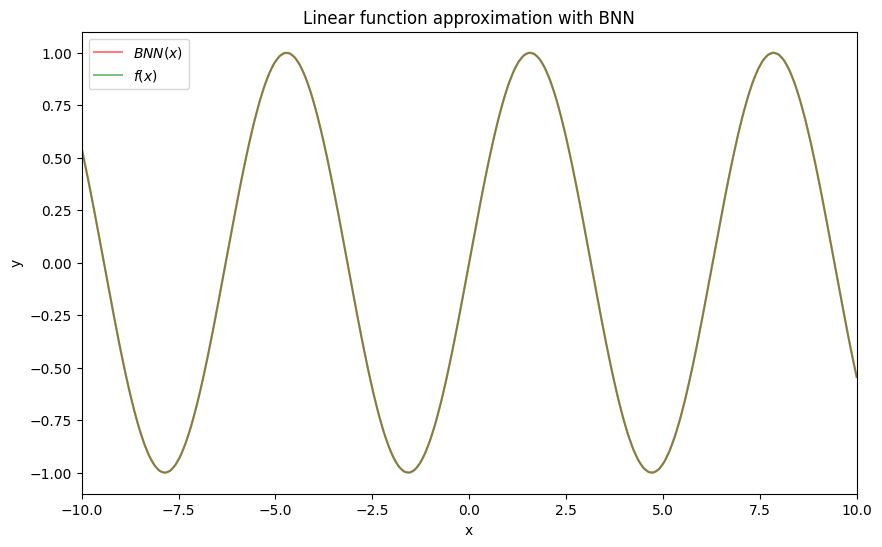

In [19]:
domain =[-10,10]
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), 1000)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)

n_segments = 150
x_values = np.linspace(-10,10,n_segments)
points = [[x.item(), function(x).item()] for x in x_values]
points

model = BaricentricNetwork(points)

with torch.no_grad():
    y_aprox = model(x_train_tensor).numpy().squeeze()
    
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
plt.plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((domain[0],domain[1]))
plt.title(f'Linear function approximation with BNN')
plt.legend(loc="upper left")
plt.show()

# Persistent entropy as a measure of similarity and determination of the number of segments to divide a continuous non-linear function for its approximation.

Let $ f(x) $ be a continuous non-linear function to approximate, and let $ BNN $ be a neural network representing a continuous piecewise linear function (CPLF). For a given desired level of precision $ \epsilon $, there exists a minimum number of segments $ m $ such that the neural network, when dividing $ f(x) $ into $ m $ equidistant segments, approximates $ f(x) $ within the specified precision $ \epsilon $. This minimum number of segments $ m $ is determined through an iterative approach where the number of segments is gradually increased, and the approximation error is evaluated using the persistent entropy metric. Note that the persistent entropy is calculated using the Lower Star filtration for computed the persistent homology, for measure similarity among piecewise linear function and time series.

Persistent entropy (dimension 0):  1.35647714138031


  0%|                                                                                           | 0/996 [00:00<?, ?it/s]

Minimum number of segment required for correct aproximation epsilon <= 0.001: 20


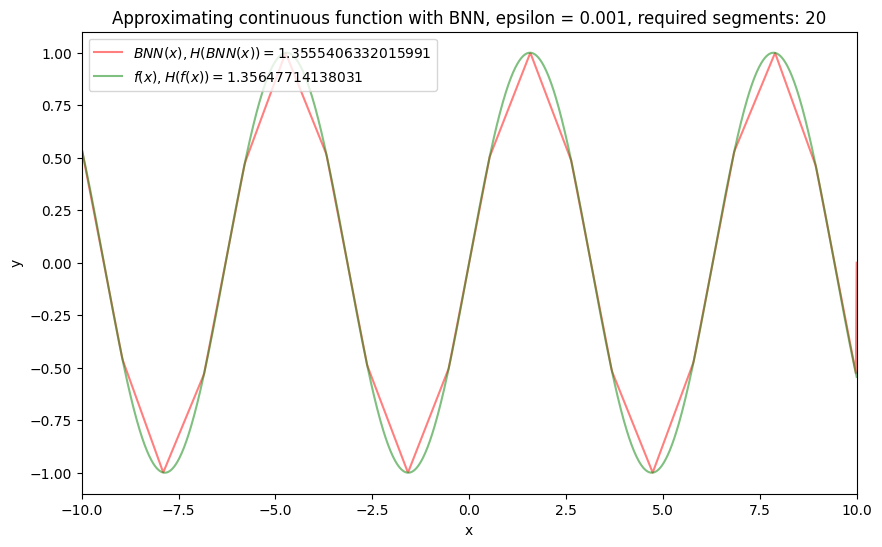

  2%|█▏                                                                                | 15/996 [00:00<00:23, 41.49it/s]


In [59]:
from tqdm import tqdm

epsilon_threshold = 0.001
min_segments = 5
max_segments = 1000   
domain =[-10,10]
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), 1000)
x_train_tensor = torch.tensor(x_train, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64)

persistence_layer = LowerStarPersistence(maxdim=0)

max_value = y_train_tensor.max()
dgms = persistence_layer(y_train_tensor)
dgms[dgms==float('inf')] = max_value + 1
entropyRef=persistent_entropyTorch(dgms)
print("Persistent entropy (dimension 0): " ,entropyRef.item())

def calculate_entropy_for_approximation(n_segments):
    x_values = np.linspace(-10,10,n_segments)
    points = [[x.item(), function(x).item()] for x in x_values]
    points
    
    model = BaricentricNetwork(points)
    
    with torch.no_grad():
        y_aprox = model(x_train_tensor)
    max_valueAprox = y_aprox.max()
    dgmsModelAprox = persistence_layer(y_aprox)
    dgmsModelAprox[dgmsModelAprox==float('inf')] = max_valueAprox + 1
    entropyModelAprox=persistent_entropyTorch(dgmsModelAprox)
    return entropyModelAprox, y_aprox
    

for n_segments in tqdm(range(min_segments, max_segments + 1)):
    entropyModelAprox, y_BNN= calculate_entropy_for_approximation(n_segments)
    error = np.abs(entropyRef.item()-entropyModelAprox.item())
    if error.item() <= epsilon_threshold:
        print(f"Minimum number of segment required for correct aproximation epsilon <= {epsilon_threshold}: {n_segments}")
        plt.figure(figsize=(10, 6))
        plt.plot(x_train, y_BNN, 'r-', label=f'$BNN(x), H(BNN(x)) = {entropyModelAprox}$', alpha=0.5)
        plt.plot(x_train, y_train, 'g-', label=f'$f(x), H(f(x)) = {entropyRef}$', alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim((domain[0],domain[1]))
        plt.title(f'Approximating continuous function with BNN, epsilon = {epsilon_threshold}, required segments: {n_segments}')
        plt.legend(loc="upper left")
        plt.show()
        break

## Persistent entropy as a measure of similarity between neural network functions

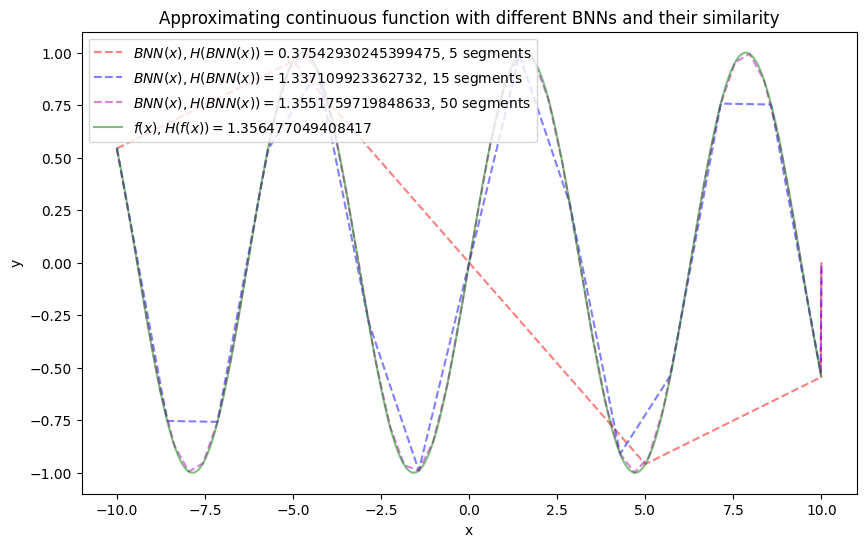

In [62]:
colors = ['r', 'b', 'm']  
entropies = [entropyRef]
plt.figure(figsize=(10, 6))
for idx, n_segments in enumerate([5, 15, 50]):
    entropyAprox, y_aprox = calculate_entropy_for_approximation(n_segments)
    entropies.append(entropyAprox)
    plt.plot(x_train, y_aprox, f'{colors[idx]}--', 
             label=f'$BNN(x), H(BNN(x)) = {entropyAprox}$, {n_segments} segments', alpha=0.5)

plt.plot(x_train, y_train, 'g-', label=f'$f(x), H(f(x)) = {entropyF}$', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Approximating continuous function with different BNNs and their similarity')
plt.legend(loc="upper left")
plt.show()